In [ ]:
# @title install dependencies
!pip install --upgrade --quiet cirq==1.7.0.dev20251110175708 # Or future version

import collections
import itertools

import attrs
import cirq
import cirq_google
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import sympy
import tunits as tu

from cirq_google.engine.qcs_notebook import authenticate_user
from cirq_google.experimental import analog_experiments as aexp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 700.1/700.1 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.2/291.2 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 74.6 MB/s eta 0:00:00


# Quantum Engine Sampler Setup

Please fill the following gcp_proj, device_name, config_name, and snapshot_id properly.

In [ ]:
gcp_proj = ""  # @param{type: "string", "placeholder": "Enter your own project"}
device_name = ""  # @param{type: "string"}
config_name = ""  # @param{type: "string"}
snapshot_id = ""  # @param{type: "string"}

authenticate_user()
engine = cirq_google.get_engine(gcp_proj)
remote_sampler = engine.get_sampler(
    device_name, snapshot_id=snapshot_id, device_config_name=config_name
)

Getting OAuth2 credentials.
Press enter after entering the verification code.
None
Authentication complete.


This is an example colab to show how to use the cirq google feature to run the digital-analog experiment.

# Set up qubits and couplers

In [ ]:
# We use GridQubit to identify a qubit. cirq.q(5, 4) represents a qubit at
# xy-coordinate (5, 4). We also use string `q5_4` for short representation.
# When the distance between two qubits in a pair is 1, that also uniquely
# identifies a coupler, i.e. `(q5_4, q5_5)` corresponds to one coupler while
# `(q5_4, q6_5)` is just a pair of qubits with no associated coupler.
metadata = (
    engine.get_processor(device_name)
    .get_config_from_run(config_name=config_name)
    .effective_device.metadata
)
# Find all qubits and couplers on the device.
qubits = list(metadata.qubit_set)
couplers = [cirq_google.Coupler(*sorted(pair)) for pair in metadata.qubit_pairs]

# Check readout fidelity

Before running experiments, we should first verify the readout fidelity. It is best practice to confirm the processor is in a healthy state to ensure reliable results.

In [ ]:
RO_err = cirq.estimate_parallel_single_qubit_readout_errors(sampler=remote_sampler, qubits=qubits)
RO_fid = {q: 1 - RO_err.one_state_errors[q] - RO_err.zero_state_errors[q] for q in qubits}

(<Axes: title={'center': '$|0\\rangle$ errors'}, xlabel='column', ylabel='row'>,
 <Axes: title={'center': '$|1\\rangle$ errors'}, xlabel='column', ylabel='row'>)

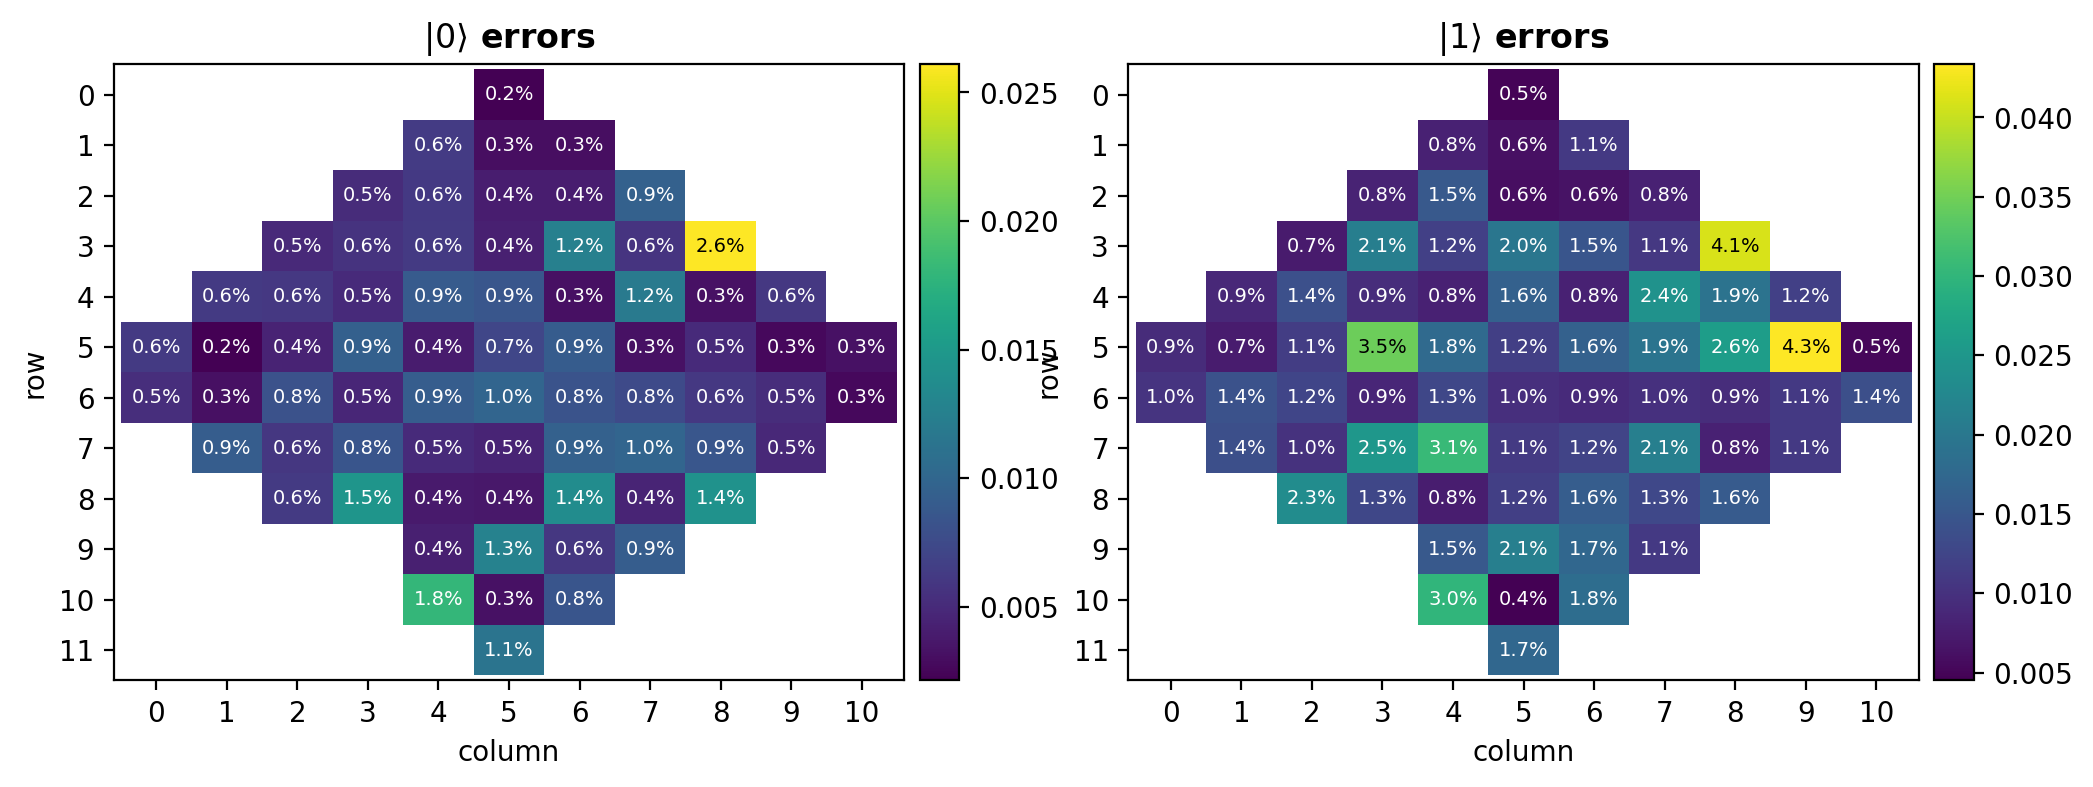

In [ ]:
RO_err.plot_heatmap(annotation_text_kwargs={"fontsize": 7})

# **Vanilla Kibble-Zurek (KZ)**

Here, we prepare a low-temperature state of the 2D quantum XY model, described by the Hamiltonian,
$$
H = \sum_{<i, j>} g_{ij} (X_i X_j+ Y_i Y_j)/2 + \sum_{i=1}^n h_iZ_i
$$
where $\sum_{<i, j>}$ represents the sum of all nearest-neighbor of qubit $i$ and $j$.


To perform adiabatic preparation, we start with a simple "staggered field", $H=h\sum_{i=1}(-1)^i  Z_i$, and prepare our system in its ground state, i.e. a state with alternating 0s and 1s. We then ramp the staggered field down, while ramping up the XY-coupling. By doing this sufficiently slowly (adiabatically), the system will remain close to the ground state.

Refer https://arxiv.org/abs/2405.17385 FIG. 3 for more information.

In this notebook, we will take three steps to achieve it.

 - First, we define a frequency trajectory -- a object that defines how the frequencies of qubits and couplers evolve over time.
 - Second, we build a KZ_experiment -- a data taker class that constructs the cirq circuit according to the frequency trajectory object and defines the sweep parameters to adjust different parameters in circuit.
 - Third, we create a KZ_analyzer to analyze the XY-correlations in the system for different ramp-up times.

## Step 1: Prepare parameters and define frequency trajectory


First, we define and visualize the frequency trajectory. Qubit frequencies and coupling strength are controlled via the `aexp.AnalogTrajectory.from_sparse_trajectory(trajectory, ...)` classmethod. The `trajectory` argument is a standard Python list of three-element tuples, where each tuple specifies the duration, the qubit frequency at the end of that duration, and the coupler strength at the end of that duration. Refer to the `make_trajectory` function below for a concrete implementation.

(<Axes: xlabel='column', ylabel='row'>,
 <matplotlib.collections.PolyCollection at 0x7865845c42f0>)

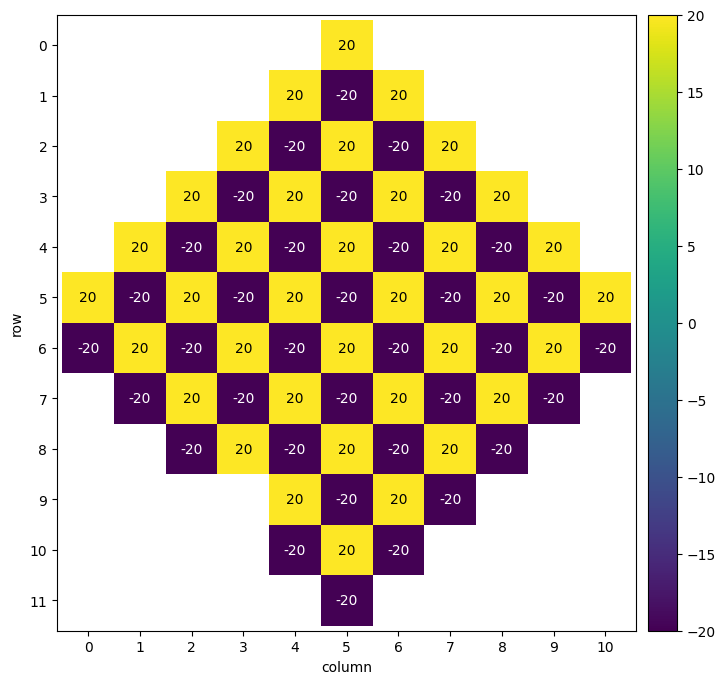

In [ ]:
# Preparing the initial staggered field
staggered_field_freq = -20 * tu.MHz
init_freq = {q: (staggered_field_freq * (-1) ** (q.row + q.col))[tu.MHz] for q in qubits}
cirq.Heatmap(init_freq).plot()

In [ ]:
def make_trajectory(
    qubits: list[cirq.GridQubit],
    couplers: list[cirq_google.Coupler],
    ramp_up_time: tu.Value,
    ramp_down_time: tu.Value,
    wait_time: tu.Value,
    staggered_field_freq: tu.Value,
    coupling_strength: tu.Value,
) -> aexp.AnalogTrajectory:
    """Construct a parametric frequency trajectory for all qubits and couplers."""
    # The trajectory is constructed through a list of three-element tuples, each of
    # which contains:
    #   - A tu.Value duration
    #   - A {qubit: freq} dictionary, where the value "freq" is a relative freq to a predefined one.
    #   - A {coupler: coupling_strength} dictionary, that maps coupler to coupling strength g.
    trajectory = [
        (ramp_up_time, {q: staggered_field_freq * (-1) ** (q.row + q.col) for q in qubits}, {}),
        (wait_time, {}, {}),
        (
            sympy.Symbol("t_r"),  # we will sweep over this variable
            {q: 0 * tu.GHz for q in qubits},
            {c: coupling_strength for c in couplers},
        ),
        # If both the qubit and coupler dictionaries are empty, we treat this as a wait time.
        (wait_time, {}, {}),
        # At the end, we turn the couplers off and bring the qubits back to their idle frequencies
        # by setting their frequencies to None:
        (ramp_down_time, {q: None for q in qubits}, {c: 0 * tu.MHz for c in couplers}),
    ]
    return aexp.AnalogTrajectory.from_sparse_trajectory(
        trajectory, qubits=qubits, couplers=couplers
    )

In [ ]:
trajectory = make_trajectory(
    qubits,
    couplers,
    ramp_up_time=10 * tu.ns,
    ramp_down_time=10 * tu.ns,
    wait_time=10 * tu.ns,
    staggered_field_freq=staggered_field_freq,
    # The absolute value of coupling strength cannot be larger than 10 MHz.
    coupling_strength=-9.9 * tu.MHz,
)

/usr/local/lib/python3.12/dist-packages/cirq_google/experimental/analog_experiments/analog_trajectory_util.py:213: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


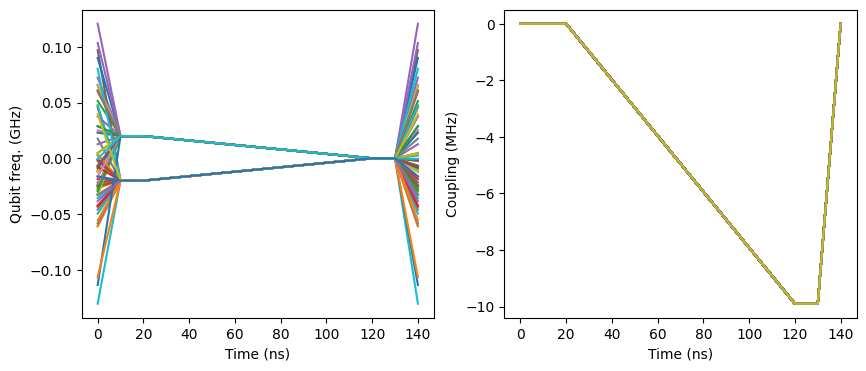

In [ ]:
# We can visualize the trajectory provide the resolving of
ax1, ax2 = trajectory.plot(
    # Here we randomly generate a qubit freq to see the different lines of qubits.
    # In the product qubit chip, each qubit idle frequency is always slightly
    # different from each other.
    resolver={"t_r": 100 * tu.ns}
)
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)

### Exercise 1: update the parameters in the make_trajectory function to see how the trajectory changes.
Hint: You can generate the trajectory with less qubits so that the plot looks better.

### Exercise 1b: use cirq.Heatmap to plot how many pairs are in the grid given a relative distance.

Hint: We do not distinguish the order so we count both q1-q2 and q2-q1.

## Step 2: An experiment class for sweeping the parameters and taking data.

The core of data acquisition via our quantum engine is encapsulated in this single line:

```
results = sampler.run_sweep(program=program, params=params, repetitions=repetitions)
```

In this context, the program is a `cirq.Circuit` that manages qubit control and coupler detuning based on your defined trajectory. A typical analog experiment circuit is composed of three distinct stages:

- State Preparation: Prepares the initial state (e.g., the staggered field used in this example).
- Analog Evolution: The central component of the experiment, constructed using the trajectory defined in Step 1. You can generate this via: `analog_pulse_circuit = aexp.GenericAnalogCircuitBuilder(trajectory).make_circuit()`
- Measurement & Post-Processing: Handles the final state readout and any necessary data transformations.

To streamline the sampling process, we typically encapsulate the circuit construction and parameter sweeping logic within a dedicated class, allowing for flexible execution based on user-defined inputs.

In [ ]:
@attrs.mutable
class KZ_experiment:
    qubits: list[cirq.GridQubit]
    couplers: list[cirq_google.Coupler]
    staggered_field_freq: tu.Value
    wait_time: tu.Value
    g: tu.Value  # Coupling strength
    g_ramp_up_times: list[tu.Value]  # We want to sweep this parameter
    ramp_up_time: tu.Value = 10 * tu.ns
    ramp_down_time: tu.Value = 10 * tu.ns

    def make_circuit(self) -> tuple[cirq.Circuit, aexp.AnalogTrajectory]:
        circ = cirq.Circuit([cirq.X.on(q) for q in self.qubits if (q.row + q.col) % 2 == 1])
        trajectory = make_trajectory(
            self.qubits,
            self.couplers,
            ramp_up_time=self.ramp_up_time,
            ramp_down_time=self.ramp_down_time,
            wait_time=self.wait_time,
            staggered_field_freq=self.staggered_field_freq,
            coupling_strength=self.g,
        )
        gac = aexp.GenericAnalogCircuitBuilder(trajectory)
        analog_pulse = gac.make_circuit()
        circ += analog_pulse
        circ += cirq.Circuit([
            # Depending on axis_phase_exponent, we make a XX/YY measurement or
            # XY/YX measurement. axis_phase_exponent is either 0 or 0.5
            cirq.PhasedXZGate(
                x_exponent=0.5,
                z_exponent=0,
                axis_phase_exponent=sympy.Symbol(f"phase_{q.col}_{q.row}"),
            ).on(q)
            for q in self.qubits
        ])
        circ += cirq.Circuit(cirq.measure(*self.qubits, key="z"))
        return circ, trajectory

    def make_qubit_axis_phase_exponent(self, width: int) -> list[cirq.Sweep]:
        # Due to missing phase information, we determine the true XX-correlation
        # from XX_true=sqrt(XX_meas^2+XY_meas^2), using the assumption that XY_true=0
        # in a thermalized state. To measure the correlator between all pairs, we
        # divide the qubits into X and Y measurement groups, using log2(N_q)
        # different partitions. The nth partition is here based on the nth digit
        # in the binary representation of the qubit index.
        per_qubit_axis_phase_exponent = []
        for i, q in enumerate(self.qubits):
            per_qubit_axis_phase_exponent.append(
                cirq.Points(f"phase_{q.col}_{q.row}", [int(bit) * 0.5 for bit in f"{i:0{width}b}"])
            )
        return per_qubit_axis_phase_exponent

    def run_circuit(self, sampler, repetitions=1000) -> cirq.Result:
        circ, trajectory = self.make_circuit()
        width = int(np.floor(np.log2(len(self.qubits) - 1)))
        q_axis_phase_exp = self.make_qubit_axis_phase_exponent(width)
        params = cirq.Points("t_r", self.g_ramp_up_times) * cirq.Zip(*q_axis_phase_exp)
        results = sampler.run_sweep(program=circ, params=params, repetitions=repetitions)
        return results

In [ ]:
g_ramp_up_times = [10 * tu.ns, 50 * tu.ns, 100 * tu.ns, 150 * tu.ns, 200 * tu.ns, 5 * tu.us]

kz_exp = KZ_experiment(
    qubits=qubits,
    couplers=couplers,
    g=-9 * tu.MHz,  # Note: the range of possible values for g is -10 MHz to 0 MHz
    g_ramp_up_times=g_ramp_up_times,
    ramp_up_time=10 * tu.ns,
    ramp_down_time=2 * tu.ns,
    wait_time=5 * tu.ns,
    staggered_field_freq=staggered_field_freq,
)

# Results is a list of cirq.Result. Each element of the list corresponds
# to a specific choice of the sweep parameter(s). The bitstrings in each
# element are accessed via results[i].measurements["z"], which gives
# a matrix with shape [num_shots * num_qubits].
results = kz_exp.run_circuit(remote_sampler, repetitions=1000)

### Exercise 2: Different data taking:
 - Make a circuit using a subset of the qubits (and corresponding couplers) and print it
 - Inspect the data sampled, such as shape, parameters, etc.
 - Optional: try a different split strategy of XY phase measurement in `make_qubit_axis_phase_exponent`.

## Step 3: Analyze the data and plot the correlations

Similar to the experiment class, we also typically create an analysis class to parse, process, and visualize the data.

In [ ]:
@attrs.frozen
class KZ_analyzer:
    results: list[cirq.Result]
    g_ramp_up_times: list[tu.Value]
    RO_fid: dict[cirq.GridQubit, float] | None = None

    def calc_dist_based_corr(
        self,
        XX_corr_dat: dict[tuple[cirq.GridQubit, cirq.GridQubit], list[float]],
        XY_corr_dat: dict[tuple[cirq.GridQubit, cirq.GridQubit], list[float]],
    ):
        """A utility function to calcuate the total correlation by distance."""
        dist_based_corr_dat_list = collections.defaultdict(list)
        for pair in itertools.combinations(qubits, r=2):
            full_corr = np.sqrt(
                np.square(np.mean(XX_corr_dat.get(pair, [0])))
                + np.square(np.mean(XY_corr_dat.get(pair, [0])))
            )

            # we do not distinguish the order of two qubits
            dist_based_corr_dat_list[pair[0] - pair[1]].append(full_corr)
            dist_based_corr_dat_list[pair[1] - pair[0]].append(full_corr)

        dist_based_corr_dat = {q: np.mean(v) for q, v in dist_based_corr_dat_list.items()}
        return dist_based_corr_dat

    def process_data_by_t(self, t_r: tu.Value, readout_correction: bool = True) -> dict[str, float]:
        """Return a dict that maps qubit-qubit displacement to correlation.

        More specifically, we calculate the correlation between all qubit pairs
        from XX and XY measurements, and average over pairs that have the same relative
        qubit position. The keys are fake qubits representing the relative positions.
        """
        # The following dictionary stores pair => correlation.
        XX_corr_dat = collections.defaultdict(list)
        XY_corr_dat = collections.defaultdict(list)

        for result in results:
            if not np.isclose(result.params["t_r"], t_r[tu.s]):
                continue
            Z_data = (-1) ** np.asarray(
                result.measurements["z"], dtype=bool
            )  # convert {0, 1} => {1, -1}
            for q1, q2 in itertools.combinations(qubits, r=2):
                phase1 = result.params[f"phase_{q1.col}_{q1.row}"]
                phase2 = result.params[f"phase_{q2.col}_{q2.row}"]
                i1 = qubits.index(q1)
                i2 = qubits.index(q2)
                # We calculate <X_1 X_2> - <X_1><X_2> if the phases for both qubits are 0 or 0.5.
                # We calculate <X_1 Y_2> - <X_1><Y_2> if the phases of the two qubits are different.
                q1_meas = Z_data[:, i1].squeeze() - np.mean(Z_data[:, i1])
                q2_meas = Z_data[:, i2].squeeze() - np.mean(Z_data[:, i2])
                if readout_correction and self.RO_fid is not None:
                    readout_correction_factor = 1 / (self.RO_fid[q1] * self.RO_fid[q2])
                else:
                    readout_correction_factor = 1
                if phase1 == phase2:
                    XX_corr_dat[(q1, q2)].append(
                        np.mean(q1_meas * q2_meas) * readout_correction_factor
                    )
                else:
                    XY_corr_dat[(q1, q2)].append(
                        np.mean(q1_meas * q2_meas) * readout_correction_factor
                    )

        return self.calc_dist_based_corr(XX_corr_dat, XY_corr_dat)

    def plot_all(self, readout_correction: bool = True):
        processed_data_list = []
        num_fig = len(self.g_ramp_up_times)
        fig, axes = plt.subplots(nrows=1, ncols=num_fig, sharey=True, figsize=(20, 3))
        for idx, (t_r, ax) in enumerate(zip(self.g_ramp_up_times, axes), start=1):
            processed_data = self.process_data_by_t(t_r, readout_correction=readout_correction)
            processed_data_list.append(processed_data)
            cirq.Heatmap(processed_data, annotation_map={None: None}, vmin=0, vmax=0.5).plot(
                ax=ax, plot_colorbar=idx == num_fig
            )
            ax.set_title(f"g_ramp_up_time = {t_r}")
            ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
        return processed_data_list

In [ ]:
kz_ana = KZ_analyzer(
    results, g_ramp_up_times, RO_fid
)  # Include readout fidelity to perform readout correction

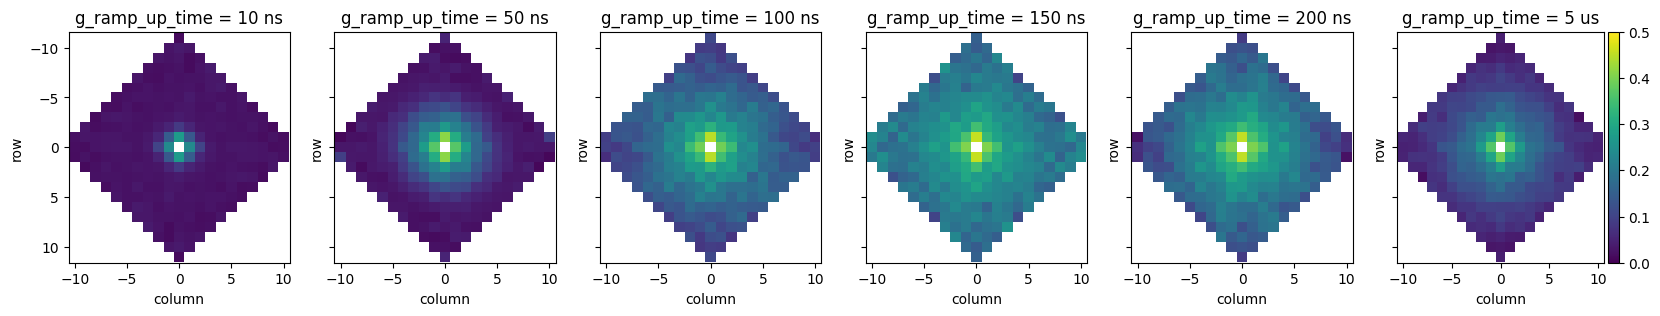

In [ ]:
processed_data_list = kz_ana.plot_all(readout_correction=True)

(0.01, 0.5)

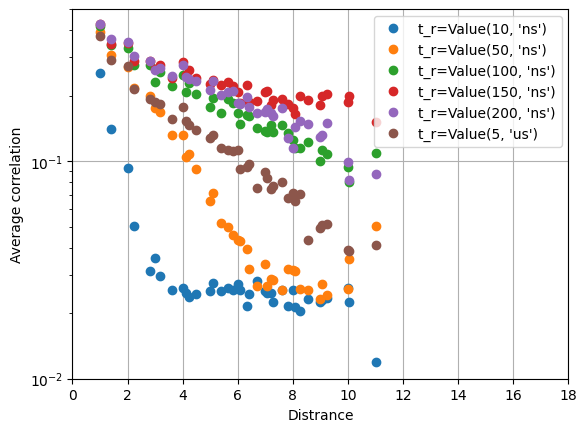

In [ ]:
# @title Example code to plot for 1D.
for idx, t_r in enumerate(kz_ana.g_ramp_up_times, start=1):
    dist_to_value = kz_ana.process_data_by_t(t_r)
    dist1d_to_value = collections.defaultdict(list)
    for dist_fake_q, value in dist_to_value.items():
        dx, dy = dist_fake_q.row, dist_fake_q.col
        dist1d_to_value[np.sqrt(dx**2 + dy**2)].append(value)

    xs = sorted(dist1d_to_value.keys())
    ys = [np.mean(dist1d_to_value[x]) for x in xs]
    plt.semilogy(xs, ys, "o", label=f"{t_r=}")
plt.xlabel("Distrance")
plt.ylabel("Average correlation")
plt.grid(True)
plt.legend()
plt.xlim(0, 18)
plt.ylim(1e-2, 0.5)

# Final exercises:
 - Study how the measured correlations depend on the ramp-down time. Do you understand the behavior? (Hint: what should happen if you ramp down and up very slowly?)
 - Study how the correlations depend on the ramp-up time. At which point does decoherence effects outweigh adiabaticity concerns?
 - Test how the previous exercise depends on coupling strength
 - Write an alternative version where you instead sweep the hold time between the ramp-up and ramp-down, and use this to extract the dependence of correlation length and energy (nearest-neighbor XX+YY correlations) on wait time
 - Edit the code such that you can switch between preparing the highest and lowest energy states of the Hamiltonian. (Hint: the energy of the state is determined by the combination of which sub-lattice has higher energy and where the |1)s are placed)
 - Edit the code so that you can also measure the qubits in the Z-basis
 - Challenge 1: modify the trajectory so that one qubit remains at a high (tunable) energy throughout the interaction part of the circuit
 - Challenge 2: modify the trajectory so that the couplers to the "special qubit" are only turned on after the adiabatic preparation